In [1]:
## LOAD MODULES ##
# Third Party
import sys
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
import psyplot.project as psy
import pandas as pd
import xarray
from netCDF4 import Dataset,date2num
import xarray as xr
from matplotlib import cm
import datetime as dt
from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray
import pickle
from matplotlib.lines import Line2D
pd.plotting.deregister_matplotlib_converters()

# First Party
sys.path.append('../utilities_tlezuo/')
# from timefunctions import *
import varfunctions as vf
import locfunctions as lf
import get_stations_timeseries as gs

###############################################################################################
# define class of pc_dict
class Point_coordinates:
    def __init__(self, shortname, name, color, marker, lat, lon, altitude, iconID, iconHSURF, iconHHL, iconHFL, height_dict):
        self.short = shortname
        self.name = name
        self.color = color
        self.marker = marker
        self.lat = lat
        self.lon = lon
        self.alt = altitude
        self.iconID = iconID 
        self.iconHSURF = iconHSURF
        self.iconHHL = iconHHL
        self.iconHFL = iconHFL
        self.hdict = height_dict 


# load pc_dict and its lists
pc_dict = np.load('../utilities_tlezuo/pc_dict.npy',allow_pickle=True).item()

INFO:numexpr.utils:Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
###############################################################################################
## DECIDE WHAT TO LOAD ##
# location
loc = pc_dict['kols']

# variable lists
spvars_raw_list=[vf.T_2M,vf.VEL_10M,vf.DIR_10M] 
spvars_rad_list=[vf.LW_d,vf.LW_u,vf.SW_d,vf.SW_u] 
spvars_flux_list=[vf.SH_s,vf.LH_s]
spvars_list=[vf.T_2M,vf.VEL_10M,vf.SH_s,vf.LH_s,vf.LWnet_s,vf.SWnet_s,] # to plot

In [3]:
###############################################################################################
## LOAD DATA STATION ##
# variables at station

# from raw
ts_data_stat_raw = gs.read_acinn(loc=loc, 
                    vars=spvars_raw_list,
                    path_ACINN= '/users/tlezuo/data/stations/ACINNiBox',
                    start_time = dt.datetime(2019,9,12,12,00).strftime("%Y-%m-%d %H:%M:%S"),
                    end_time = dt.datetime(2019,9,14,12,00).strftime("%Y-%m-%d %H:%M:%S"),
                    correct_direction=True)
ts_data_stat_raw['dt'] = pd.to_datetime(ts_data_stat_raw["timestamp"])

# from rad
if loc.short in ['arb','hoch','weer','kols']:
    ts_data_stat_rad = gs.read_acinn(loc=loc, 
                        vars=spvars_rad_list,
                        path_ACINN= '/users/tlezuo/data/stations/ACINNiBox',
                        start_time = dt.datetime(2019,9,12,12,00).strftime("%Y-%m-%d %H:%M:%S"),
                        end_time = dt.datetime(2019,9,14,12,00).strftime("%Y-%m-%d %H:%M:%S"),
                        correct_direction=True)
    ts_data_stat_rad['dt'] = pd.to_datetime(ts_data_stat_rad["timestamp"])
    ## CLACULATE NET RAD FLUXES ##
    ts_data_stat_rad['sob_s']=ts_data_stat_rad['sw_down']-ts_data_stat_rad['sw_up']
    ts_data_stat_rad['thb_s']=ts_data_stat_rad['lw_down']-ts_data_stat_rad['lw_up']
else: 
    ts_data_stat_rad=pd.DataFrame()
# from fluxl12

if loc.short in ['hoch','weer','kols','terf','egg']:
    ts_data_stat_flux = gs.read_acinn(loc=loc, 
                        vars=spvars_flux_list,
                        path_ACINN= '/users/tlezuo/data/stations/ACINNiBox',
                        start_time = dt.datetime(2019,9,12,12,00).strftime("%Y-%m-%d %H:%M:%S"),
                        end_time = dt.datetime(2019,9,14,12,00).strftime("%Y-%m-%d %H:%M:%S"),
                        correct_direction=True)
    ts_data_stat_flux['dt'] = pd.to_datetime(ts_data_stat_flux["timestamp"])
    ## REVERSE FLUXES SIGN ##
    ts_data_stat_flux['shfl_s']=-ts_data_stat_flux['shfl_s']
    ts_data_stat_flux['lhfl_s']=-ts_data_stat_flux['lhfl_s']
else: 
    ts_data_stat_flux=pd.DataFrame()


6 files found for this station
found T_2M as tair2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Kolsass_FLUXL12_7e207498/data.csv
found VEL_10M as meanu2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Kolsass_FLUXL12_7e207498/data.csv
found DIR_10M as wind_dir2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Kolsass_FLUXL12_7e207498/data.csv
found T_2M as tair2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Kolsass_FLUXL3_672be429/data.csv
Index(['columns: T_2M', 'columns: VEL_10M', 'columns: DIR_10M',
       'columns: timestamp'],
      dtype='object')
6 files found for this station
found lw_down as lw_in_avg in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Kolsass_RAW_58a00cfd/data.csv
found lw_up as lw_out_avg in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Kolsass_RAW_58a00cfd/data.csv
found sw_down as sw_in_avg in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Kolsass_RAW_58a00cfd/data.csv
found sw_up as sw_ou

In [4]:
###############################################################################################
## LOAD DATA ICON TS ##
#run2
import glob, os
os.chdir("/store/s83/tlezuo/RUN2_reference/out_hfsu")
ts_data_icon_RUN2 = xarray.open_mfdataset('*0000.nc')
ts_data_icon_RUN2 = ts_data_icon_RUN2.sel(ncells=loc.iconID)
#run3
os.chdir("/store/s83/tlezuo/RUN3_noconv/out_hfsu")
ts_data_icon_RUN3 = xarray.open_mfdataset('*0000.nc')
ts_data_icon_RUN3 = ts_data_icon_RUN3.sel(ncells=loc.iconID)
#run4
os.chdir("/store/s83/tlezuo/RUN4_cosmolev/out_hfsu")
ts_data_icon_RUN4 = xarray.open_mfdataset('*0000.nc')
ts_data_icon_RUN4 = ts_data_icon_RUN4.sel(ncells=loc.iconID)
#run5
os.chdir("/store/s83/tlezuo/RUN5_extended/out_std")
ts_data_icon_RUN5 = xarray.open_mfdataset('*0000.nc')
ts_data_icon_RUN5 = ts_data_icon_RUN5.sel(ncells=loc.iconID)



In [5]:

## CLACULATE VEL AND DIR, SET T[°C] ##
# run2
ts_data_icon_RUN2 = ts_data_icon_RUN2.assign(VEL_10M=vf.calculate_wind_vel_from_uv(ts_data_icon_RUN2['u_10m'],ts_data_icon_RUN2['v_10m']))
ts_data_icon_RUN2 = ts_data_icon_RUN2.assign(DIR_10M=vf.calculate_wind_dir_from_uv(ts_data_icon_RUN2['u_10m'],ts_data_icon_RUN2['v_10m']))
ts_data_icon_RUN2['T_2M'] = ts_data_icon_RUN2['T_2M']-273.15
# run3
ts_data_icon_RUN3 = ts_data_icon_RUN3.assign(VEL_10M=vf.calculate_wind_vel_from_uv(ts_data_icon_RUN3['u_10m'],ts_data_icon_RUN3['v_10m']))
ts_data_icon_RUN3 = ts_data_icon_RUN3.assign(DIR_10M=vf.calculate_wind_dir_from_uv(ts_data_icon_RUN3['u_10m'],ts_data_icon_RUN3['v_10m']))
ts_data_icon_RUN3['T_2M'] = ts_data_icon_RUN3['T_2M']-273.15
# run4
ts_data_icon_RUN4 = ts_data_icon_RUN4.assign(VEL_10M=vf.calculate_wind_vel_from_uv(ts_data_icon_RUN4['u_10m'],ts_data_icon_RUN4['v_10m']))
ts_data_icon_RUN4 = ts_data_icon_RUN4.assign(DIR_10M=vf.calculate_wind_dir_from_uv(ts_data_icon_RUN4['u_10m'],ts_data_icon_RUN4['v_10m']))
ts_data_icon_RUN4['T_2M'] = ts_data_icon_RUN4['T_2M']-273.15
# run5
ts_data_icon_RUN5 = ts_data_icon_RUN5.assign(VEL_10M=vf.calculate_wind_vel_from_uv(ts_data_icon_RUN5['u_10m'],ts_data_icon_RUN5['v_10m']))
ts_data_icon_RUN5 = ts_data_icon_RUN5.assign(DIR_10M=vf.calculate_wind_dir_from_uv(ts_data_icon_RUN5['u_10m'],ts_data_icon_RUN5['v_10m']))
ts_data_icon_RUN5['T_2M'] = ts_data_icon_RUN5['T_2M']-273.15

In [22]:
ts_data_icon_RUN5.depth.values

array([0.000e+00, 5.000e+00, 2.000e+01, 6.000e+01, 1.800e+02, 5.400e+02,
       1.620e+03, 4.860e+03, 1.458e+04])

[Text(18151.5, 0, '12'),
 Text(18151.583333333332, 0, '14'),
 Text(18151.666666666668, 0, '16'),
 Text(18151.75, 0, '18'),
 Text(18151.833333333332, 0, '20'),
 Text(18151.916666666668, 0, '22'),
 Text(18152.0, 0, '00'),
 Text(18152.083333333332, 0, '02'),
 Text(18152.166666666668, 0, '04'),
 Text(18152.25, 0, '06'),
 Text(18152.333333333332, 0, '08'),
 Text(18152.416666666668, 0, '10'),
 Text(18152.5, 0, '12'),
 Text(18152.583333333332, 0, '14'),
 Text(18152.666666666668, 0, '16'),
 Text(18152.75, 0, '18'),
 Text(18152.833333333332, 0, '20'),
 Text(18152.916666666668, 0, '22'),
 Text(18153.0, 0, '00'),
 Text(18153.083333333332, 0, '02'),
 Text(18153.166666666668, 0, '04'),
 Text(18153.25, 0, '06'),
 Text(18153.333333333332, 0, '08'),
 Text(18153.416666666668, 0, '10'),
 Text(18153.5, 0, '12')]

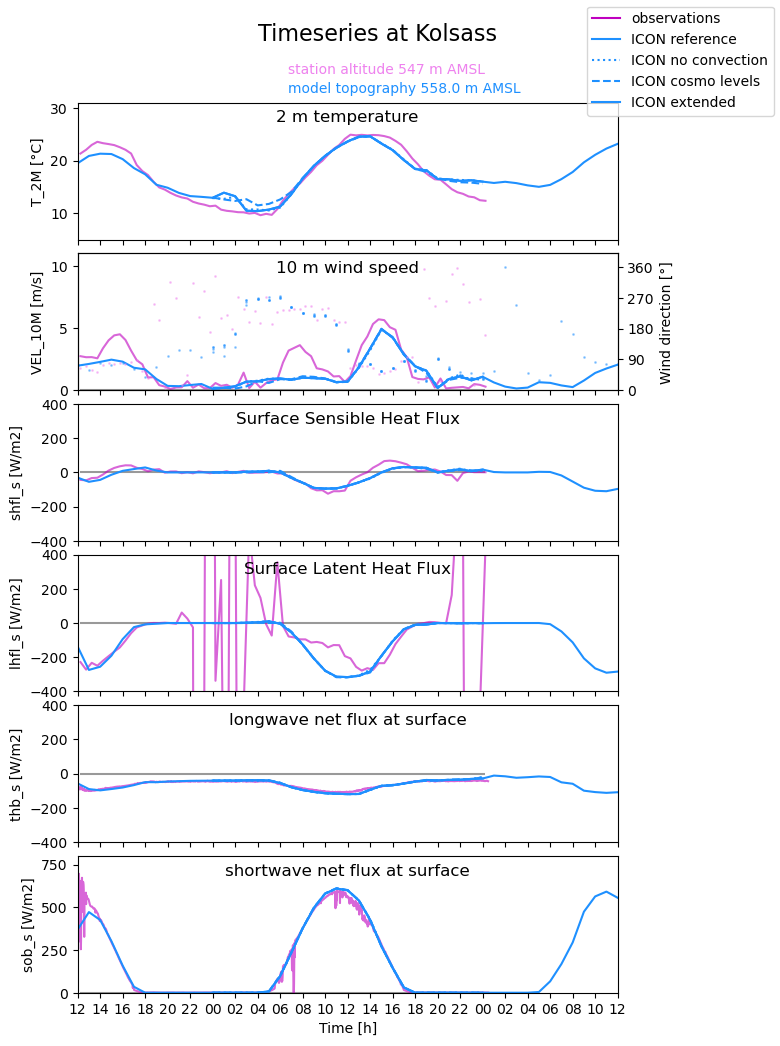

In [6]:
# time range
startdate_plot = dt.datetime(2019,9,12,12,00)
enddate_plot = dt.datetime(2019,9,14,12,00)
plotfreq_plot = '2h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)

# figure settings
fig, ax = plt.subplots(len(spvars_list),1, figsize=(8,10))
plt.subplots_adjust(bottom=0.01, right=0.8, top=0.9,hspace=0.1)
fig.suptitle('Timeseries at '+loc.name, fontsize=16)
ax[0].annotate('station altitude '+str(loc.alt)+' m AMSL', xy=(0.42,1.17),xytext=(0.39,1.21),xycoords=('axes fraction','axes fraction'),color='violet')
ax[0].annotate('model topography '+str(loc.iconHSURF.round())+' m AMSL', xy=(0.42,0.82),xytext=(0.39,1.07),xycoords=('axes fraction','axes fraction'),color='dodgerblue')
for ax_ts,spvar in zip(ax.flatten(),spvars_list):
        # OBS
        handle_obs = Line2D([0], [0], color='m',linestyle='solid')
        if spvar.name in ts_data_stat_raw.columns:
                ax_ts.plot(ts_data_stat_raw['dt'],np.transpose(ts_data_stat_raw[spvar.name]),color='m',alpha=0.6, label='observations')
        elif spvar.name in ts_data_stat_rad.columns:
                ax_ts.plot(ts_data_stat_rad['dt'],np.transpose(ts_data_stat_rad[spvar.name]),color='m',alpha=0.6, label='observations')
        elif spvar.name in ts_data_stat_flux.columns:
                ax_ts.plot(ts_data_stat_flux['dt'],np.transpose(ts_data_stat_flux[spvar.name]),color='m',alpha=0.6, label='observations')
        # ICON 
        # ax_ts.plot(plotdates_model,ts_data_icon[spvar.name],color='dodgerblue',label='ICON')
        plotdates_model = pd.date_range(startdate_plot,enddate_plot,freq='1h')
        # plotdates_model = ts_data_icon_RUN2.time
        handle_I2 = Line2D([0], [0], color='dodgerblue',linestyle='solid')
        handle_I3 = Line2D([0], [0], color='dodgerblue',linestyle='dotted')
        handle_I4 = Line2D([0], [0], color='dodgerblue',linestyle='dashed')
        handle_I5 = Line2D([0], [0], color='dodgerblue',linestyle='solid')
        # ax_ts.plot(ts_data_icon_RUN1.time,ts_data_icon_RUN1.TKE,color='gray',label='ICON old')
        ax_ts.plot(ts_data_icon_RUN2.time,ts_data_icon_RUN2[spvar.name],color='dodgerblue',label='ICON reference')
        ax_ts.plot(ts_data_icon_RUN3.time,ts_data_icon_RUN3[spvar.name],color='dodgerblue',linestyle = 'dotted', label='ICON no convection')
        ax_ts.plot(ts_data_icon_RUN4.time,ts_data_icon_RUN4[spvar.name],color='dodgerblue',linestyle = 'dashed',label='ICON cosmo levels')
        ax_ts.plot(ts_data_icon_RUN5.time,ts_data_icon_RUN5[spvar.name],color='dodgerblue',linestyle = 'solid',label='ICON extended')

        # plotting options
        ax_ts.set_ylim(spvar.min,spvar.max)
        ax_ts.set_xlim(startdate_plot,enddate_plot)
        # ax_ts.grid()
        ax_ts.set_title(spvar.title, y=1.0, pad=-14)
        ax_ts.set_xlabel('Time [h]')
        ax_ts.set_xticks(plotdates_plot)
        ax_ts.set_xticklabels([])
        ax_ts.set_ylabel(spvar.name+' '+spvar.units)
        ax_ts.hlines(y=0, xmin=ts_data_stat_raw['dt'][0],xmax=ts_data_stat_raw['dt'][-1],colors='k',alpha=0.4)
        # ax_ts.annotate('(obs at '+str(loc.hdict[spvar.name])+' m AGL)', xy=(0.40,0.92),xytext=(0.39,0.92),xycoords=('axes fraction','axes fraction'),color='violet')

        ##################################################################################################
        # ## DIR if VEL is plotted ##
        if spvar.name == 'VEL_10M':
                # plot
                ax_ts_2 = ax_ts.twinx()
                # obs
                ax_ts_2.scatter(ts_data_stat_raw['dt'],np.transpose(ts_data_stat_raw['DIR_10M']),color='violet',alpha=0.4,s=1) # station obs
                # model
                ax_ts_2.scatter(ts_data_icon_RUN2.time,ts_data_icon_RUN2['DIR_10M'],color='dodgerblue',alpha=0.4,s=1)
                ax_ts_2.scatter(ts_data_icon_RUN3.time,ts_data_icon_RUN3['DIR_10M'],color='dodgerblue',alpha=0.4,s=1)
                ax_ts_2.scatter(ts_data_icon_RUN4.time,ts_data_icon_RUN4['DIR_10M'],color='dodgerblue',alpha=0.4,s=1)
                ax_ts_2.scatter(ts_data_icon_RUN5.time,ts_data_icon_RUN5['DIR_10M'],color='dodgerblue',alpha=0.4,s=1)

                # plotting options
                ax_ts_2.set_ylim(0,400)
                ax_ts_2.set_yticks(np.arange(0,365,90))
                ax_ts_2.set_ylabel('Wind direction [°]')
                ax_ts_2.set_xlim(startdate_plot,enddate_plot)
                ax_ts_2.set_xticks(plotdates_plot)
                ax_ts_2.set_xticklabels([])

legend_handles=[handle_obs,handle_I2,handle_I3, handle_I4,handle_I5]
legend_labels=['observations','ICON reference','ICON no convection','ICON cosmo levels','ICON extended']
fig.legend(legend_handles,legend_labels)
ax[-1].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])

In [7]:
## SELECT WHICH RUN TO USE FOR SEB
ts_data_icon_SEB = ts_data_icon_RUN5

## CALCULATE TOTAL SEB ##
SW_obs = ts_data_stat_rad['sob_s'].resample('H').interpolate('cubic')#[1:24]
LW_obs = ts_data_stat_rad['thb_s'].resample('H').interpolate('cubic')#[1:24]
SH_obs = ts_data_stat_flux['shfl_s'].resample('min').bfill().resample('H').interpolate('cubic')#[1:]
LH_obs = ts_data_stat_flux['lhfl_s'].resample('min').bfill().resample('H').interpolate('cubic')#[1:]
T_obs = ts_data_stat_raw['T_2M'].resample('min').bfill().resample('H').interpolate('cubic')[1:]
SEB_obs = SW_obs + LW_obs + SH_obs + LH_obs
SEB_obs
SEB_model = ts_data_icon_SEB['sob_s'] + ts_data_icon_SEB['thb_s'] + ts_data_icon_SEB['shfl_s'] + ts_data_icon_SEB['lhfl_s']

In [8]:
## GETTING TIMES ##
# separation times
sunset_12 = dt.datetime(2019,9,12,17,33)
sunrise_13 = dt.datetime(2019,9,13,4,48)
midday_13 = dt.datetime(2019,9,13,12,00)
sunset_13 = dt.datetime(2019,9,13,17,31)
sunrise_14 = dt.datetime(2019,9,14,4,49)
separation_dates = [sunset_12,sunrise_13,midday_13,sunset_13,sunrise_14]
centered_dates = [(separation_dates[i] + (separation_dates[i+1] - separation_dates[i]) / 2) for i in range(0,len(separation_dates)-1)]

# VW period
if loc.short == 'kols':
    vw_start = dt.datetime(2019,9,13,12,0)
    vw_s_int = 12
    vw_end = dt.datetime(2019,9,13,18,30)
    vw_e_int = 18.5
elif loc.short == 'weer':
    vw_start = dt.datetime(2019,9,13,12,0)
    vw_s_int = 12
    vw_end = dt.datetime(2019,9,13,16,30)
    vw_e_int = 16.5
elif loc.short == 'hoch':
    vw_start = dt.datetime(2019,9,13,12,0)
    vw_s_int = 12
    vw_end = dt.datetime(2019,9,13,19,0)
    vw_e_int = 19

In [9]:
## DEFINE FILL BETWEEN FUNCTION
def fill_between_dates(start,end,ax,color,alpha):
    ax.fill_betweenx(np.arange(-4000,4000,20),np.full(400,start),np.full(400,end),color=color,alpha=alpha,zorder=0)

In [10]:
hfbl_tendencies = xarray.open_mfdataset('/users/tlezuo/icon-vis/data/data_hfbl/sumbl_ts_data_RUN3_noconv.nc')
hfbl_tendencies=hfbl_tendencies.sel(ncells=loc.subsetID)
TEND_sum = hfbl_tendencies.ddt_temp_clcov + hfbl_tendencies.ddt_temp_drag + hfbl_tendencies.ddt_temp_pconv + hfbl_tendencies.ddt_temp_radlw + hfbl_tendencies.ddt_temp_radsw + hfbl_tendencies.ddt_temp_turb + hfbl_tendencies.ddt_temp_dyn
T2M_change_model = [ts_data_icon_SEB.T_2M[i].values -  ts_data_icon_SEB.T_2M[i-1].values for i in range (1,len(ts_data_icon_SEB.time))]
TL80_change_model = [ts_data_icon_SEB.T[i][-1].values - ts_data_icon_SEB.T[i-1][-1].values for i in range (1,len(ts_data_icon_SEB.time))]
# T_change_obs = np.zeros(2)
T_change_obs = [T_obs[i] - T_obs[i-1] for i in range (1,len(T_obs))]

In [11]:
len(T2M_change_model)

48

ValueError: x and y must have same first dimension, but have shapes (24,) and (48, 1)

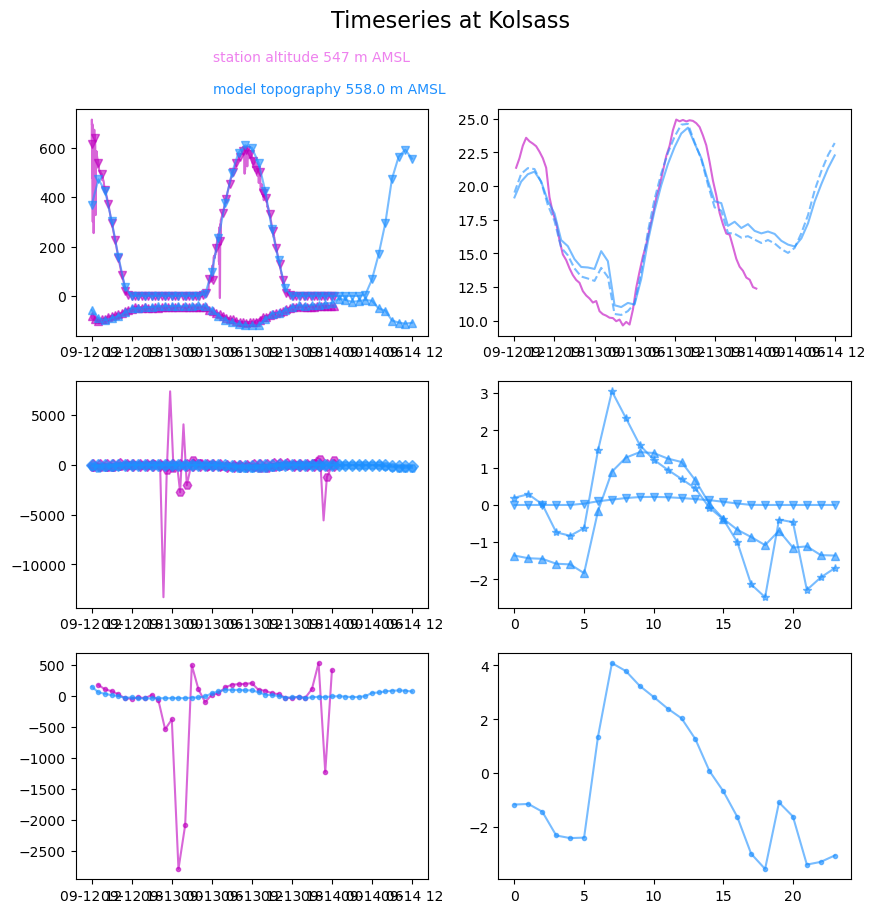

In [12]:
######################################## COMBINED SEB ############################################
pvar_ax1 = vf.T_2M
# time range
startdate_plot = dt.datetime(2019,9,12,12,00)
enddate_plot = dt.datetime(2019,9,14,12,00)
plotfreq_plot = '2h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)

# figure settings
fig, ax = plt.subplots(3,2, figsize=(10,10))
fig.suptitle('Timeseries at '+loc.name, fontsize=16)
ax[0,0].annotate('station altitude '+str(loc.alt)+' m AMSL', xy=(0.42,1.17),xytext=(0.39,1.21),xycoords=('axes fraction','axes fraction'),color='violet')
ax[0,0].annotate('model topography '+str(loc.iconHSURF.round())+' m AMSL', xy=(0.42,0.82),xytext=(0.39,1.07),xycoords=('axes fraction','axes fraction'),color='dodgerblue')

# OBS
handle_obs = Line2D([0], [0], color='m',linestyle='solid')
ax[0,1].plot(ts_data_stat_raw['dt'],np.transpose(ts_data_stat_raw[pvar_ax1.name]),color='m',alpha=0.6, label='observations')
ax[0,0].plot(ts_data_stat_rad['dt'],np.transpose(ts_data_stat_rad['sob_s']),color='m',alpha=0.6, marker="v",markevery=30)
ax[0,0].plot(ts_data_stat_rad['dt'],np.transpose(ts_data_stat_rad['thb_s']),color='m',alpha=0.6, marker="^",markevery=30)      
ax[1,0].plot(ts_data_stat_flux['dt'],np.transpose(ts_data_stat_flux['shfl_s']),color='m',alpha=0.6, marker="D",markevery=2,)
ax[1,0].plot(ts_data_stat_flux['dt'],np.transpose(ts_data_stat_flux['lhfl_s']),color='m',alpha=0.6, marker="H",markevery=2,)#markerfacecolor='None',linestyle = 'None')
ax[2,0].plot(SEB_obs,color='m',alpha=0.6,marker=".")

# ICON 
plotdates_model = pd.date_range(startdate_plot,enddate_plot,freq='1h')
# plotdates_model = ts_data_icon_SEB.time
handle_I = Line2D([0], [0], color='dodgerblue',linestyle='solid')

ax[0,1].plot(ts_data_icon_SEB.time,ts_data_icon_SEB[pvar_ax1.name],color='dodgerblue',alpha=0.6, linestyle = 'dashed')
ax[0,1].plot(ts_data_icon_SEB.time,ts_data_icon_SEB['T'][:,-1].values-273.15,color='dodgerblue',alpha=0.6, linestyle = 'solid')
ax[0,0].plot(ts_data_icon_SEB.time,ts_data_icon_SEB['sob_s'],color='dodgerblue',alpha=0.6, marker="v")
ax[0,0].plot(ts_data_icon_SEB.time,ts_data_icon_SEB['thb_s'],color='dodgerblue',alpha=0.6, marker="^")       
ax[1,0].plot(ts_data_icon_SEB.time,ts_data_icon_SEB['shfl_s'],color='dodgerblue',alpha=0.6, marker="D",)
ax[1,0].plot(ts_data_icon_SEB.time,ts_data_icon_SEB['lhfl_s'],color='dodgerblue',alpha=0.6, marker="H",)
ax[2,0].plot(ts_data_icon_SEB.time,SEB_model,color='dodgerblue',alpha=0.6,marker=".")

# TENDENCIES
# ax4.plot(hfbl_tendencies.ddt_temp_clcov, color='r',alpha=0.6, marker=".",linestyle = 'None',markerfacecolor='None',label='condensation')
# ax4.plot(hfbl_tendencies.ddt_temp_drag, color='dodgerblue',alpha=0.6, marker=".",linestyle = 'None',markerfacecolor='None',label='drag')
# ax4.plot(hfbl_tendencies.ddt_temp_pconv,color='dodgerblue',alpha=0.6, marker="1",linestyle = 'None',markerfacecolor='None',label='convection')
# ax4.plot(hfbl_tendencies.ddt_temp_radlw, color='dodgerblue',alpha=0.6, marker="^",linestyle = 'None',markerfacecolor='None',label='LW')
# ax4.plot(hfbl_tendencies.ddt_temp_radsw, color='dodgerblue',alpha=0.6, marker="v",linestyle = 'None',markerfacecolor='None',label='SW')
# ax4.plot(hfbl_tendencies.ddt_temp_turb, color='dodgerblue',alpha=0.6, marker="*",linestyle = 'None',markerfacecolor='None',label='turbulence')
# ax4.plot(hfbl_tendencies.ddt_temp_dyn, color='dodgerblue',alpha=0.6, marker="o",linestyle = 'None',markerfacecolor='None',label='advection')
ax[1,1].plot(hfbl_tendencies.hour, hfbl_tendencies.ddt_temp_radlw, color='dodgerblue',alpha=0.6, marker="^",label='LW')
ax[1,1].plot(hfbl_tendencies.hour, hfbl_tendencies.ddt_temp_radsw, color='dodgerblue',alpha=0.6, marker="v",label='SW')
ax[1,1].plot(hfbl_tendencies.hour, hfbl_tendencies.ddt_temp_turb, color='dodgerblue',alpha=0.6, marker="*",label='turbulence')
# ax4.scatter(hfbl_tendencies.ddt_temp_dyn, color='dodgerblue',alpha=0.6, marker="o",label='advection')

ax[2,1].plot(hfbl_tendencies.hour, TEND_sum, color='dodgerblue',alpha=0.6, label = 'TEND sum',marker=".")
ax[2,1].plot(hfbl_tendencies.hour, T2M_change_model, color='dodgerblue',alpha=0.6,linestyle = 'dashed', label = 'T2M change')
ax[2,1].plot(hfbl_tendencies.hour, TL80_change_model, color='dodgerblue',alpha=0.6,linestyle = 'solid', label = 'TL80 change')
ax[2,1].plot(np.arange(1,23,1), T_change_obs, color='m',alpha=0.6,linestyle = 'solid', label = 'Tobs change')
# ax[2,1].legend(loc='lower right')

# plotting options T
ax[0,1].set_ylim(pvar_ax1.min,pvar_ax1.max)
ax[0,1].set_title(pvar_ax1.title, y=1.0, pad=-14)
ax[0,1].set_ylabel(pvar_ax1.name+' '+pvar_ax1.units)

ax[0,1].set_xlim(startdate_plot,enddate_plot)
ax[0,1].set_xticks(plotdates_plot)
ax[0,1].set_xticklabels([])
ax[0,1].hlines(y=0, xmin=ts_data_stat_raw['dt'][0],xmax=ts_data_stat_raw['dt'][-1],colors='k',alpha=0.4)

# plotting options SEB Rad
ax[0,0].set_ylim(-200,801)
ax[0,0].set_title('SEB Radiation Terms', y=1.0, pad=-14)
ax[0,0].set_ylabel('[W/m2]')

ax[0,0].set_xlim(startdate_plot,enddate_plot)
ax[0,0].set_xticks(plotdates_plot)
ax[0,0].set_xticklabels([])
ax[0,0].hlines(y=0, xmin=ts_data_stat_raw['dt'][0],xmax=ts_data_stat_raw['dt'][-1],colors='k',alpha=0.4)

# plotting options SEB Turb
ax[1,0].set_ylim(-400,201)
ax[1,0].set_title('SEB Turbulence Terms', y=1.0, pad=-14)
ax[1,0].set_ylabel('[W/m2]')

ax[1,0].set_xlim(startdate_plot,enddate_plot)
ax[1,0].set_xticks(plotdates_plot)
ax[1,0].set_xticklabels([])
ax[1,0].hlines(y=0, xmin=ts_data_stat_raw['dt'][0],xmax=ts_data_stat_raw['dt'][-1],colors='k',alpha=0.4)

# plotting options SEb sum
ax[2,0].set_ylim(-100,501)
ax[2,0].set_title('SEB sum', y=1.0, pad=-14)
ax[2,0].set_ylabel('[W/m2]')

ax[2,0].set_xlim(startdate_plot,enddate_plot)
ax[2,0].set_xticks(plotdates_plot)
# ax[2,0].set_xticklabels([])
ax[2,0].hlines(y=0, xmin=ts_data_stat_raw['dt'][0],xmax=ts_data_stat_raw['dt'][-1],colors='k',alpha=0.4)
ax[2,0].set_xlabel('Time [h]')
ax[2,0].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])

# plotting options TEND terms
ax[1,1].set_ylim(-5,5.1)
ax[1,1].set_title('TEND terms', y=1.0, pad=-14)
ax[1,1].set_ylabel('[K/h]')

ax[1,1].set_xlim(hfbl_tendencies['hour'][0],hfbl_tendencies['hour'][-1]+1)
ax[1,1].set_xticks(np.arange(0,25,2))
ax[1,1].set_xticklabels([])
ax[1,1].hlines(y=0, xmin=hfbl_tendencies['hour'][0],xmax=hfbl_tendencies['hour'][-1],colors='k',alpha=0.4)

# plotting options TENS sum
ax[2,1].set_ylim(-5,5.1)
ax[2,1].set_title('TEND sum and T change', y=1.0, pad=-14)
ax[2,1].set_ylabel('[K/h]')

ax[2,1].set_xlabel('Time [h]')
ax[2,1].set_xlim(hfbl_tendencies['hour'][0],hfbl_tendencies['hour'][-1]+1)
ax[2,1].set_xticks(np.arange(0,25,2))
# ax[2,1].set_xticklabels([])
ax[2,1].hlines(y=0, xmin=hfbl_tendencies['hour'][0],xmax=hfbl_tendencies['hour'][-1],colors='k',alpha=0.4)

# LEGEND
handle_2M = Line2D([0], [0], color='k', linestyle = 'dashed')
handle_L81 = Line2D([0], [0], color='k', linestyle = 'solid')
handle_SW = Line2D([0], [0], color='k', marker="v",linestyle = 'None')
handle_LW = Line2D([0], [0], color='k', marker="^",linestyle = 'None')
handle_SH = Line2D([0], [0], color='k', marker="D",linestyle = 'None')
handle_LH = Line2D([0], [0], color='k', marker="H",linestyle = 'None')
handle_turb = Line2D([0], [0], color='k', marker="*",linestyle = 'None')
legend_handles=[handle_obs,handle_I,handle_2M,handle_L81,handle_SW, handle_LW,handle_SH,handle_LH, handle_turb]
legend_labels=['observations','ICON','2m','10m','SW net','LW_net','SH','LH', 'turbulence']
fig.legend(legend_handles,legend_labels,loc='upper right')

# SUNRISE SUNSET
ax[0,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4)
ax[1,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4)
ax[2,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4)
ax[0,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4)
ax[1,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,4.8),np.full(400,17.5),color='papayawhip',alpha=0.4)
ax[2,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,4.8),np.full(400,17.5),color='papayawhip',alpha=0.4)

ax[0,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip')
ax[1,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip')
ax[2,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip')
ax[0,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip')
ax[1,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_s_int),np.full(400,vw_e_int),color='papayawhip')
ax[2,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_s_int),np.full(400,vw_e_int),color='papayawhip')

In [ ]:
## DATA AVG PERIODS ##
def resample_to_periods(start, end):
    start_ind_obs = T_obs.index.get_loc(start, method='nearest')
    end_ind_obs  = T_obs.index.get_loc(end, method='nearest')
    print('Calculating period')
    print('obs from '+str(T_obs.index[start_ind_obs])+' to '+str(T_obs.index[end_ind_obs]))
    print('icon from '+str(ts_data_icon_SEB.T[start_ind_obs+1].time.values)+' to '+str(ts_data_icon_SEB.T[end_ind_obs+1].time.values))
    mean_dict = {}
    # obs
    mean_dict ['sob_s_obs'] = ts_data_stat_rad['sob_s'][start.strftime("%Y-%m-%d %H:%M:%S"):end.strftime("%Y-%m-%d %H:%M:%S")].mean()
    mean_dict ['thb_s_obs'] = ts_data_stat_rad['thb_s'][start.strftime("%Y-%m-%d %H:%M:%S"):end.strftime("%Y-%m-%d %H:%M:%S")].mean()
    mean_dict ['shfl_s_obs'] = ts_data_stat_flux['shfl_s'][start.strftime("%Y-%m-%d %H:%M:%S"):end.strftime("%Y-%m-%d %H:%M:%S")].mean()
    mean_dict ['lhfl_s_obs'] = ts_data_stat_flux['lhfl_s'][start.strftime("%Y-%m-%d %H:%M:%S"):end.strftime("%Y-%m-%d %H:%M:%S")].mean()
    mean_dict ['SEB_obs'] = SEB_obs[start.strftime("%Y-%m-%d %H:%M:%S"):end.strftime("%Y-%m-%d %H:%M:%S")].mean()
    mean_dict ['T_change_obs'] = np.sum(T_change_obs[start_ind_obs:end_ind_obs])
    # icon
    mean_dict ['sob_s_model'] = float(ts_data_icon_SEB['sob_s'].sel(time=slice(start.strftime("%Y-%m-%d %H:%M:%S"),end.strftime("%Y-%m-%d %H:%M:%S"))).mean('time'))
    mean_dict ['thb_s_model'] = float(ts_data_icon_SEB['thb_s'].sel(time=slice(start.strftime("%Y-%m-%d %H:%M:%S"),end.strftime("%Y-%m-%d %H:%M:%S"))).mean('time'))
    mean_dict ['shfl_s_model'] = float(ts_data_icon_SEB['shfl_s'].sel(time=slice(start.strftime("%Y-%m-%d %H:%M:%S"),end.strftime("%Y-%m-%d %H:%M:%S"))).mean('time'))
    mean_dict ['lhfl_s_model'] = float(ts_data_icon_SEB['lhfl_s'].sel(time=slice(start.strftime("%Y-%m-%d %H:%M:%S"),end.strftime("%Y-%m-%d %H:%M:%S"))).mean('time'))
    mean_dict ['SEB_model'] = float(SEB_model.sel(time=slice(start.strftime("%Y-%m-%d %H:%M:%S"),end.strftime("%Y-%m-%d %H:%M:%S"))).mean('time'))
    mean_dict ['T2M_change_model'] = np.sum(T2M_change_model[start_ind_obs+1:end_ind_obs+1])
    mean_dict ['TL80_change_model'] = np.sum(TL80_change_model[start_ind_obs+1:end_ind_obs+1])
    mean_dict ['ddt_temp_radlw'] = float(hfbl_tendencies['ddt_temp_radlw'].sel(hour=slice(int(start.strftime("%H")),int(end.strftime("%H")))).sum('hour'))
    mean_dict ['ddt_temp_radsw'] = float(hfbl_tendencies['ddt_temp_radsw'].sel(hour=slice(int(start.strftime("%H")),int(end.strftime("%H")))).sum('hour'))
    mean_dict ['ddt_temp_turb'] = float(hfbl_tendencies['ddt_temp_turb'].sel(hour=slice(int(start.strftime("%H")),int(end.strftime("%H")))).sum('hour'))
    mean_dict ['TEND_sum'] = float(TEND_sum.sel(hour=slice(int(start.strftime("%H")),int(end.strftime("%H")))).sum('hour'))
    return mean_dict

mean_n1 = resample_to_periods(sunset_12, sunrise_13)
mean_m1 = resample_to_periods(sunrise_13, midday_13)
mean_vw = resample_to_periods(midday_13, sunset_13)
mean_n2 = resample_to_periods(sunset_13, sunrise_14)


/tmp/ipykernel_58868/2911529539.py:3: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_ind_obs = T_obs.index.get_loc(start, method='nearest')
/tmp/ipykernel_58868/2911529539.py:4: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end_ind_obs  = T_obs.index.get_loc(end, method='nearest')
/tmp/ipykernel_58868/2911529539.py:3: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_ind_obs = T_obs.index.get_loc(start, method='nearest')
/tmp/ipykernel_58868/2911529539.py:4: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end_ind_obs  = T_obs.index.get_loc(e

Calculating period
obs from 2019-09-12 18:00:00 to 2019-09-13 05:00:00
icon from 2019-09-12T18:00:00.000000000 to 2019-09-13T05:00:00.000000000
Calculating period
obs from 2019-09-13 05:00:00 to 2019-09-13 12:00:00
icon from 2019-09-13T05:00:00.000000000 to 2019-09-13T12:00:00.000000000


/tmp/ipykernel_58868/2911529539.py:3: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_ind_obs = T_obs.index.get_loc(start, method='nearest')
/tmp/ipykernel_58868/2911529539.py:4: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end_ind_obs  = T_obs.index.get_loc(end, method='nearest')
/tmp/ipykernel_58868/2911529539.py:3: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_ind_obs = T_obs.index.get_loc(start, method='nearest')
/tmp/ipykernel_58868/2911529539.py:4: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end_ind_obs  = T_obs.index.get_loc(e

Calculating period
obs from 2019-09-13 12:00:00 to 2019-09-13 18:00:00
icon from 2019-09-13T12:00:00.000000000 to 2019-09-13T18:00:00.000000000
Calculating period
obs from 2019-09-13 18:00:00 to 2019-09-14 00:00:00
icon from 2019-09-13T18:00:00.000000000 to 2019-09-14T00:00:00.000000000


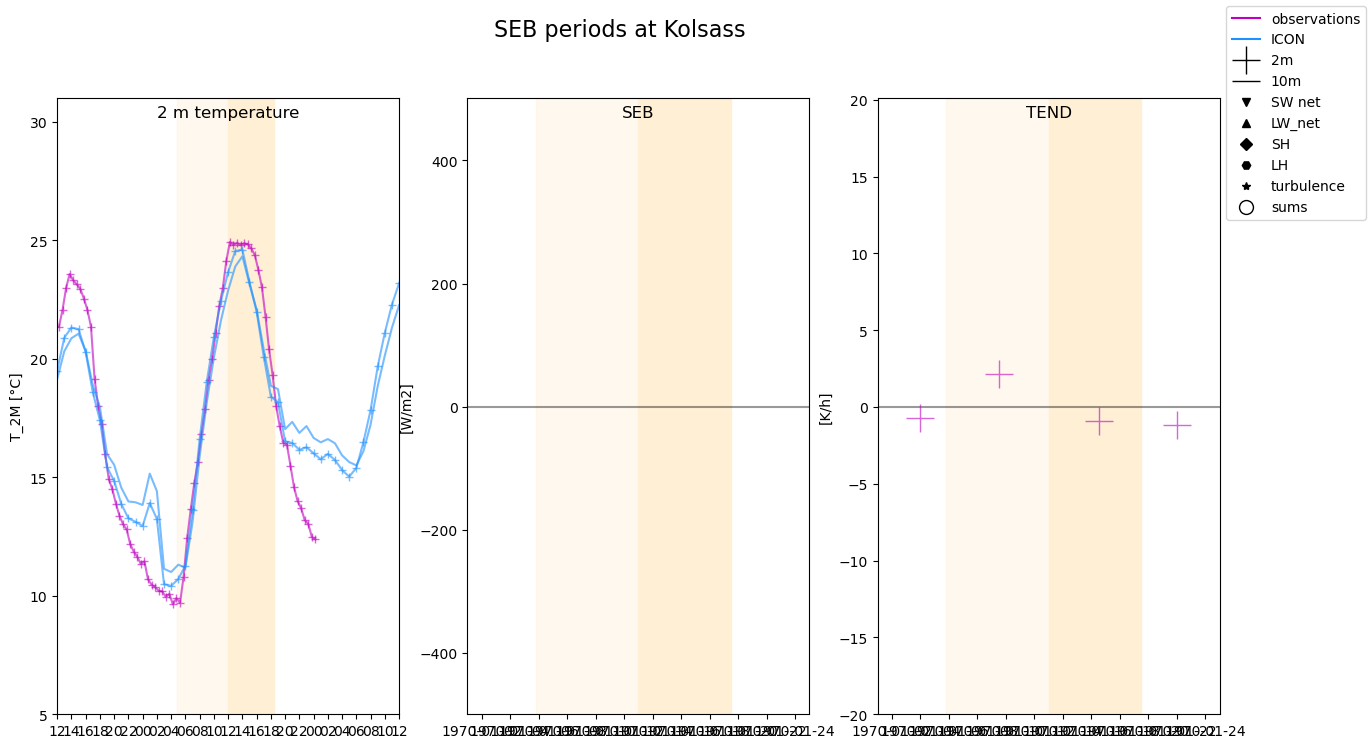

In [ ]:
######################################## PERIOD PLOT SEB ############################################
# figure settings
fig, ax = plt.subplots(1,3, figsize=(15,8))
fig.suptitle('SEB periods at '+loc.name, fontsize=16)

# T ax1
ax[0].plot(ts_data_stat_raw['dt'],np.transpose(ts_data_stat_raw['T_2M']),color='m',alpha=0.6, marker='+')
ax[0].plot(ts_data_icon_SEB.time,ts_data_icon_SEB['T'][:,-1].values-273.15,color='dodgerblue',alpha=0.6)#, marker='+')
ax[0].plot(ts_data_icon_SEB.time,ts_data_icon_SEB['T_2M'],color='dodgerblue',alpha=0.6, marker='+')

# SEB ax2
#obs
ax[1].scatter(centered_dates,[mean_n1['sob_s_obs'],mean_m1['sob_s_obs'],mean_vw['sob_s_obs'],mean_n2['sob_s_obs']],color='m',alpha=0.6, marker="v")
ax[1].scatter(centered_dates,[mean_n1['thb_s_obs'],mean_m1['thb_s_obs'],mean_vw['thb_s_obs'],mean_n2['thb_s_obs']],color='m',alpha=0.6, marker="^")
ax[1].scatter(centered_dates,[mean_n1['shfl_s_obs'],mean_m1['shfl_s_obs'],mean_vw['shfl_s_obs'],mean_n2['shfl_s_obs']],color='m',alpha=0.6, marker="D")
ax[1].scatter(centered_dates,[mean_n1['lhfl_s_obs'],mean_m1['lhfl_s_obs'],mean_vw['lhfl_s_obs'],mean_n2['lhfl_s_obs']],color='m',alpha=0.6, marker="H")
ax[1].plot(centered_dates,[mean_n1['SEB_obs'],mean_m1['SEB_obs'],mean_vw['SEB_obs'],mean_n2['SEB_obs']],color='m',alpha=0.6, marker=".",linestyle='None',markerfacecolor='None',markersize = 20)
#icon
ax[1].scatter(centered_dates,[mean_n1['sob_s_model'],mean_m1['sob_s_model'],mean_vw['sob_s_model'],mean_n2['sob_s_model']],color='dodgerblue',alpha=0.6, marker="v")
ax[1].scatter(centered_dates,[mean_n1['thb_s_model'],mean_m1['thb_s_model'],mean_vw['thb_s_model'],mean_n2['thb_s_model']],color='dodgerblue',alpha=0.6, marker="^")
ax[1].scatter(centered_dates,[mean_n1['shfl_s_model'],mean_m1['shfl_s_model'],mean_vw['shfl_s_model'],mean_n2['shfl_s_model']],color='dodgerblue',alpha=0.6, marker="D")
ax[1].scatter(centered_dates,[mean_n1['lhfl_s_model'],mean_m1['lhfl_s_model'],mean_vw['lhfl_s_model'],mean_n2['lhfl_s_model']],color='dodgerblue',alpha=0.6, marker="H")
ax[1].plot(centered_dates,[mean_n1['SEB_model'],mean_m1['SEB_model'],mean_vw['SEB_model'],mean_n2['SEB_model']],color='dodgerblue',alpha=0.6, marker=".",linestyle='None',markerfacecolor='None',markersize = 20)

# tendencies ax 3
ax[2].scatter(centered_dates,[mean_n1['ddt_temp_radlw'],mean_m1['ddt_temp_radlw'],mean_vw['ddt_temp_radlw'],mean_n2['ddt_temp_radlw']],color='dodgerblue',alpha=0.6, marker="^")
ax[2].scatter(centered_dates,[mean_n1['ddt_temp_radsw'],mean_m1['ddt_temp_radsw'],mean_vw['ddt_temp_radsw'],mean_n2['ddt_temp_radsw']],color='dodgerblue',alpha=0.6, marker="v")
ax[2].scatter(centered_dates,[mean_n1['ddt_temp_turb'],mean_m1['ddt_temp_turb'],mean_vw['ddt_temp_turb'],mean_n2['ddt_temp_turb']],color='dodgerblue',alpha=0.6, marker="*")
ax[2].plot(centered_dates,[mean_n1['TEND_sum'],mean_m1['TEND_sum'],mean_vw['TEND_sum'],mean_n2['TEND_sum']],color='dodgerblue',alpha=0.6, marker=".",linestyle='None',markerfacecolor='None',markersize = 20)
ax[2].plot(centered_dates,[mean_n1['T2M_change_model'],mean_m1['T2M_change_model'],mean_vw['T2M_change_model'],mean_n2['T2M_change_model']],color='dodgerblue',alpha=0.6, marker="+",linestyle='None',markerfacecolor='None',markersize = 20)
ax[2].plot(centered_dates,[mean_n1['TL80_change_model'],mean_m1['TL80_change_model'],mean_vw['TL80_change_model'],mean_n2['TL80_change_model']],color='dodgerblue',alpha=0.6, marker="_",linestyle='None',markerfacecolor='None',markersize = 20)
ax[2].plot([3,8.5,15.5,21],[mean_n1['T_change_obs'],mean_m1['T_change_obs'],mean_vw['T_change_obs'],mean_n2['T_change_obs']],color='m',alpha=0.6, marker="+",linestyle='None',markerfacecolor='None',markersize = 20)


# plotting options T
ax[0].set_ylim(pvar_ax1.min,pvar_ax1.max)
ax[0].set_title(pvar_ax1.title, y=1.0, pad=-14)
ax[0].set_ylabel(pvar_ax1.name+' '+pvar_ax1.units)
ax[0].set_xlim(startdate_plot,enddate_plot)
ax[0].set_xticks(plotdates_plot)
ax[0].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])

# plotting options SEB 
ax[1].set_ylim(-500,501)
ax[1].set_title('SEB', y=1.0, pad=-14)
ax[1].set_ylabel('[W/m2]')
ax[1].set_xlim(0,24)
ax[1].set_xticks(np.arange(1,25,2))
# ax[1].set_xticklabels([])
ax[1].hlines(y=0, xmin=0,xmax=24,colors='k',alpha=0.4)

# plotting options TEND
ax[2].set_ylim(-20,20.1)
ax[2].set_title('TEND', y=1.0, pad=-14)
ax[2].set_ylabel('[K/h]')
ax[2].set_xlim(0,24)
ax[2].set_xticks(np.arange(1,25,2))
# ax[2].set_xticklabels([])
ax[2].hlines(y=0, xmin=0,xmax=24,colors='k',alpha=0.4)

# LEGEND
handle_I = Line2D([0], [0], color='dodgerblue',linestyle='solid')
handle_obs = Line2D([0], [0], color='m',linestyle='solid')
handle_2M = Line2D([0], [0], color='k', marker = '+',linestyle = 'None',markersize=20)
handle_L81 = Line2D([0], [0], color='k', marker = '_',linestyle = 'None',markersize=20)
handle_SW = Line2D([0], [0], color='k', marker="v",linestyle = 'None')
handle_LW = Line2D([0], [0], color='k', marker="^",linestyle = 'None')
handle_SH = Line2D([0], [0], color='k', marker="D",linestyle = 'None')
handle_LH = Line2D([0], [0], color='k', marker="H",linestyle = 'None')
handle_turb = Line2D([0], [0], color='k', marker="*",linestyle = 'None')
handle_tot = Line2D([0], [0], color='k', marker=".",linestyle = 'None',markerfacecolor='None',markersize=20)
legend_handles=[handle_obs,handle_I,handle_2M,handle_L81,handle_SW, handle_LW,handle_SH,handle_LH, handle_turb,handle_tot]
legend_labels=['observations','ICON','2m','10m','SW net','LW_net','SH','LH', 'turbulence','sums']
fig.legend(legend_handles,legend_labels,loc='upper right')

# SUNRISE SUNSET
sunrise_time = dt.datetime(2019,9,13,4,48)
sunset_time = dt.datetime(2019,9,13,17,30)
ax[0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4,zorder=0)
ax[1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,4.8),np.full(400,17.5),color='papayawhip',alpha=0.4,zorder=0)
ax[2].fill_betweenx(np.arange(-4000,4000,20),np.full(400,4.8),np.full(400,17.5),color='papayawhip',alpha=0.4,zorder=0)
# VW PERIOD
ax[0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip',zorder=0)
ax[1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_s_int),np.full(400,vw_e_int),color='papayawhip',zorder=0)
ax[2].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_s_int),np.full(400,vw_e_int),color='papayawhip',zorder=0)

In [ ]:
centered_dates[1:3]

[datetime.datetime(2019, 9, 13, 8, 24),
 datetime.datetime(2019, 9, 13, 14, 45, 30)]

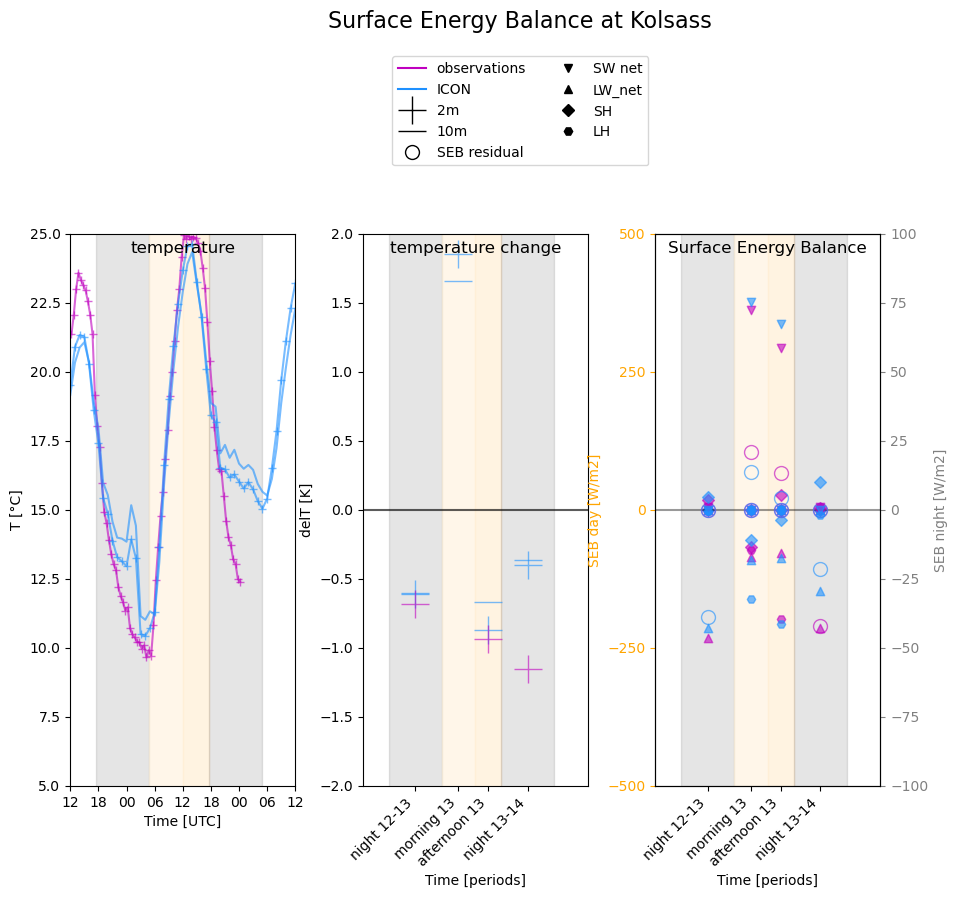

In [ ]:
######################################## PERIOD PLOT SEB ############################################
# figure settings
fig, ax = plt.subplots(1,3, figsize=(12,8))
plt.subplots_adjust(bottom=0.01, right=0.8, top=0.7,wspace=0.3)
fig.suptitle('Surface Energy Balance at '+loc.name, fontsize=16)

# T ax1
ax[0].plot(ts_data_stat_raw['dt'],np.transpose(ts_data_stat_raw['T_2M']),color='m',alpha=0.6, marker='+')
ax[0].plot(ts_data_icon_SEB.time,ts_data_icon_SEB['T'][:,-1].values-273.15,color='dodgerblue',alpha=0.6)#, marker='+')
ax[0].plot(ts_data_icon_SEB.time,ts_data_icon_SEB['T_2M'],color='dodgerblue',alpha=0.6, marker='+')
# plotting options T
ax[0].set_ylim(5,25)
ax[0].set_title('temperature', y=1.0, pad=-14)
ax[0].set_ylabel('T '+pvar_ax1.units)
ax[0].set_xlim(startdate_plot,enddate_plot)
ax[0].set_xticks(plotdates_plot[::3])
ax[0].set_xlabel('Time [UTC]')
# ax[0].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot[::3]])
ax[0].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot[::3]])

# delT ax 1
# ax_delT = ax[0].twinx()
ax[1].plot(centered_dates,[mean_n1['T2M_change_model'],mean_m1['T2M_change_model'],mean_vw['T2M_change_model'],mean_n2['T2M_change_model']],color='dodgerblue',alpha=0.6, marker="+",linestyle='None',markerfacecolor='None',markersize = 20)
ax[1].plot(centered_dates,[mean_n1['TL80_change_model'],mean_m1['TL80_change_model'],mean_vw['TL80_change_model'],mean_n2['TL80_change_model']],color='dodgerblue',alpha=0.6, marker="_",linestyle='None',markerfacecolor='None',markersize = 20)
ax[1].plot(centered_dates,[mean_n1['T_change_obs'],mean_m1['T_change_obs'],mean_vw['T_change_obs'],mean_n2['T_change_obs']],color='m',alpha=0.6, marker="+",linestyle='None',markerfacecolor='None',markersize = 20)
ax[1].hlines(y=0, xmin=startdate_plot,xmax=enddate_plot,colors='k',alpha=0.4)
ax[1].set_ylim(-2,2)
ax[1].set_title('temperature change', y=1.0, pad=-14)
ax[1].set_ylabel('delT [K]')
ax[1].set_xlabel('Time [periods]')
ax[1].set_xlim(startdate_plot,enddate_plot)
ax[1].set_xticks(centered_dates)
ax[1].set_xticklabels(['night 12-13','morning 13','afternoon 13','night 13-14'],rotation = 45, ha="right")
ax[1].hlines(y=0, xmin=startdate_plot,xmax=enddate_plot,colors='k',alpha=0.4)

# SEB ax2
#obs
ax_night = ax[2].twinx()
ax[2].scatter(centered_dates,[0,mean_m1['sob_s_obs'],mean_vw['sob_s_obs'],0],color='m',alpha=0.6, marker="v")
ax_night.scatter(centered_dates,[mean_n1['sob_s_obs'],0,0,mean_n2['sob_s_obs']],color='m',alpha=0.6, marker="v")
ax[2].scatter(centered_dates,[0,mean_m1['thb_s_obs'],mean_vw['thb_s_obs'],0],color='m',alpha=0.6, marker="^")
ax_night.scatter(centered_dates,[mean_n1['thb_s_obs'],0,0,mean_n2['thb_s_obs']],color='m',alpha=0.6, marker="^")
ax[2].scatter(centered_dates,[0,mean_m1['shfl_s_obs'],mean_vw['shfl_s_obs'],0],color='m',alpha=0.6, marker="D")
ax_night.scatter(centered_dates,[mean_n1['shfl_s_obs'],0,0,mean_n2['shfl_s_obs']],color='m',alpha=0.6, marker="D")
ax[2].scatter(centered_dates,[0,mean_m1['lhfl_s_obs'],mean_vw['lhfl_s_obs'],0],color='m',alpha=0.6, marker="H")
ax_night.scatter(centered_dates,[mean_n1['lhfl_s_obs'],0,0,mean_n2['lhfl_s_obs']],color='m',alpha=0.6, marker="H")
ax[2].plot(centered_dates,[0,mean_m1['SEB_obs'],mean_vw['SEB_obs'],0],color='m',alpha=0.6, marker=".",linestyle='None',markerfacecolor='None',markersize = 20)
ax_night.plot(centered_dates,[mean_n1['SEB_obs'],0,0,mean_n2['SEB_obs']],color='m',alpha=0.6, marker=".",linestyle='None',markerfacecolor='None',markersize = 20)

#icon
ax[2].scatter(centered_dates,[0,mean_m1['sob_s_model'],mean_vw['sob_s_model'],0],color='dodgerblue',alpha=0.6, marker="v")
ax_night.scatter(centered_dates,[mean_n1['sob_s_model'],0,0,mean_n2['sob_s_model']],color='dodgerblue',alpha=0.6, marker="v")
ax[2].scatter(centered_dates,[0,mean_m1['thb_s_model'],mean_vw['thb_s_model'],0],color='dodgerblue',alpha=0.6, marker="^")
ax_night.scatter(centered_dates,[mean_n1['thb_s_model'],0,0,mean_n2['thb_s_model']],color='dodgerblue',alpha=0.6, marker="^")
ax[2].scatter(centered_dates,[0,mean_m1['shfl_s_model'],mean_vw['shfl_s_model'],0],color='dodgerblue',alpha=0.6, marker="D")
ax_night.scatter(centered_dates,[mean_n1['shfl_s_model'],0,0,mean_n2['shfl_s_model']],color='dodgerblue',alpha=0.6, marker="D")
ax[2].scatter(centered_dates,[0,mean_m1['lhfl_s_model'],mean_vw['lhfl_s_model'],0],color='dodgerblue',alpha=0.6, marker="H")
ax_night.scatter(centered_dates,[mean_n1['lhfl_s_model'],0,0,mean_n2['lhfl_s_model']],color='dodgerblue',alpha=0.6, marker="H")
ax[2].plot(centered_dates,[0,mean_m1['SEB_model'],mean_vw['SEB_model'],0],color='dodgerblue',alpha=0.6, marker=".",linestyle='None',markerfacecolor='None',markersize = 20)
ax_night.plot(centered_dates,[mean_n1['SEB_model'],0,0,mean_n2['SEB_model']],color='dodgerblue',alpha=0.6, marker=".",linestyle='None',markerfacecolor='None',markersize = 20)
# plotting options SEB 
ax[2].set_ylim(-500,500)
ax[2].set_title('Surface Energy Balance', y=1.0, pad=-14)
ax[2].set_ylabel('SEB day [W/m2]', color = 'orange')
ax[2].set_yticks([-500,-250,0,250,500])
ax[2].tick_params(axis='y', colors='orange')
ax[2].set_xlim(startdate_plot,enddate_plot)
ax[2].set_xticks(centered_dates)
ax[2].set_xlabel('Time [periods]')
ax[2].set_xticklabels(['night 12-13','morning 13','afternoon 13','night 13-14'],rotation = 45, ha="right")
ax[2].hlines(y=0, xmin=startdate_plot,xmax=enddate_plot,colors='k',alpha=0.4)
# ax night
ax_night.set_ylim(-100,100)
ax_night.set_ylabel('SEB night [W/m2]', color = 'gray')
ax_night.tick_params(axis='y', colors='gray')
# ax_night.hlines(y=0, xmin=startdate_plot,xmax=enddate_plot,colors='k',alpha=0.4)

# LEGEND
handle_I = Line2D([0], [0], color='dodgerblue',linestyle='solid')
handle_obs = Line2D([0], [0], color='m',linestyle='solid')
handle_2M = Line2D([0], [0], color='k', marker = '+',linestyle = 'None',markersize=20)
handle_L81 = Line2D([0], [0], color='k', marker = '_',linestyle = 'None',markersize=20)
handle_SW = Line2D([0], [0], color='k', marker="v",linestyle = 'None')
handle_LW = Line2D([0], [0], color='k', marker="^",linestyle = 'None')
handle_SH = Line2D([0], [0], color='k', marker="D",linestyle = 'None')
handle_LH = Line2D([0], [0], color='k', marker="H",linestyle = 'None')
handle_tot = Line2D([0], [0], color='k', marker=".",linestyle = 'None',markerfacecolor='None',markersize=20)
legend_handles=[handle_obs,handle_I,handle_2M,handle_L81,handle_tot,handle_SW, handle_LW,handle_SH,handle_LH,]
legend_labels=['observations','ICON','2m','10m', 'SEB residual','SW net','LW_net','SH','LH',]
fig.legend(legend_handles,legend_labels,ncol=2,loc='upper center',bbox_to_anchor=(0.5,0.93))

# SUNRISE SUNSET
fill_between_dates(sunset_12,sunrise_13,ax[0],'k',0.1)
fill_between_dates(sunrise_13,midday_13,ax[0],'papayawhip',0.5)
fill_between_dates(midday_13,sunset_13,ax[0],'papayawhip',0.7)
fill_between_dates(sunset_13,sunrise_14,ax[0],'k',0.1)

fill_between_dates(sunset_12,sunrise_13,ax[1],'k',0.1)
fill_between_dates(sunrise_13,midday_13,ax[1],'papayawhip',0.5)
fill_between_dates(midday_13,sunset_13,ax[1],'papayawhip',0.7)
fill_between_dates(sunset_13,sunrise_14,ax[1],'k',0.1)

fill_between_dates(sunset_12,sunrise_13,ax[2],'k',0.1)
fill_between_dates(sunrise_13,midday_13,ax[2],'papayawhip',0.5)
fill_between_dates(midday_13,sunset_13,ax[2],'papayawhip',0.7)
fill_between_dates(sunset_13,sunrise_14,ax[2],'k',0.1)